# 03. Court Vision EDA Spatial Plots vs Raw Data Processing

Exploratory visuals from the Djokovic vs Tsitsipas AO 2023 Final + other Tsitsipas matches.

In the process, this involves:
Converting the raw court vision json data into a more understandable format. 
Dictionary keys in the raw data is now "encoded" by non-descriptive numbers with an "a" prefix. 
Processed data keys are derived from the old (~2021) format and inferences from the real match data/scoreline from the online court-vision web app.

In [1]:
import pandas as pd
import numpy as np
import re
import json
import glob

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import get_cmap

# Matplotlib for drawing the court
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.colors
from matplotlib.colors import to_rgba_array
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerLineCollection

from PIL import Image

from highlight_text import HighlightText, ax_text, fig_text

### Plotting Utilities

In [17]:
def createTennisCourt(linecolor='white', ax=None, lw=2, alp=1, court_xlims=(-13,13), court_ylims=(-15,15)):
    '''
    Plots a Tennis Court with adjustable line colour, width and court limits
    '''
    if ax is None:
        ax = plt.gca()

    # Court Dimensions
    width_doub = 10.97
    width_sing = 8.23
    length_half = 11.89
    length_service = 6.4

    # Baseline Bottom
    ax.plot([-width_doub/2,width_doub/2], [-length_half]*2, color=linecolor, linewidth=lw, alpha=alp)
    # Baseline Top
    ax.plot([-width_doub/2,width_doub/2], [length_half]*2, color=linecolor, linewidth=lw, alpha=alp)
    # Horizontal Center Line
    ax.plot([-width_doub/2,width_doub/2], [0]*2, color=linecolor, linewidth=lw, alpha=alp)

    # Service Line Bottom
    ax.plot([-width_sing/2,width_sing/2], [-length_service]*2, color=linecolor, linewidth=lw, alpha=alp)
    # Service Line Top
    ax.plot([-width_sing/2,width_sing/2], [length_service]*2, color=linecolor, linewidth=lw, alpha=alp)


    ax.plot([-width_doub/2]*2, [-length_half,length_half], color=linecolor, linewidth=lw, alpha=alp)
    ax.plot([width_doub/2]*2, [-length_half,length_half], color=linecolor, linewidth=lw, alpha=alp)

    ax.plot([-width_sing/2]*2, [-length_half,length_half], color=linecolor, linewidth=lw, alpha=alp)
    ax.plot([width_sing/2]*2, [-length_half,length_half], color=linecolor, linewidth=lw, alpha=alp)

    ax.plot([0]*2, [-length_service,length_service], color=linecolor, linewidth=lw, alpha=alp)

    # Baseline thing
    ax.plot([0]*2, [-length_half,-length_half+0.5], color=linecolor, linewidth=lw, alpha=alp)
    ax.plot([0]*2, [length_half,length_half-0.5], color=linecolor, linewidth=lw, alpha=alp)


    # ax.set_xlim(-width_doub/2-6.41,width_doub/2+6.41)
    # ax.set_ylim(-length_half-9,length_half+9)
    #plt.gca().invert_yaxis()

    ax.set_xlim(court_xlims)
    ax.set_ylim(court_ylims)

In [18]:
def _create_segments(xstart, ystart, xend, yend, n_segments=100, multi_segment=False):
    # For plotting lines in the "comet" style from mplsoccer (expanding width from start to end)
    if multi_segment:
        x = np.linspace(xstart, xend, n_segments + 1)
        y = np.linspace(ystart, yend, n_segments + 1)
        points = np.array([x, y]).T
        points = np.concatenate([points, np.expand_dims(points[:, -1, :], 1)], axis=1)
        points = np.expand_dims(points, 1)
        segments = np.concatenate([points[:, :, :-2, :],
                                   points[:, :, 1:-1, :],
                                   points[:, :, 2:, :]], axis=1)
        segments = np.transpose(segments, (0, 2, 1, 3)).reshape((-1, 3, 2))
    else:
        segments = np.transpose(np.array([[xstart, ystart], [xend, yend]]), (2, 0, 1))
    return segments

def _lines_no_cmap(xstart, ystart, xend, yend, lw=None, color=None, ax=None,
                n_segments=100, multi_segment=False, **kwargs):
    segments = _create_segments(xstart, ystart, xend, yend,
                                n_segments=n_segments, multi_segment=multi_segment)
    color = to_rgba_array(color)
    if (color.shape[0] > 1) and (color.shape[0] != xstart.size):
        raise ValueError("xstart and color must be the same size")
    line_collection = LineCollection(segments, color=color, linewidth=lw, snap=False, **kwargs)
    line_collection = ax.add_collection(line_collection)
    return line_collection

## Load Data

In [3]:
# Read a sample data for processing example
with open("../data/court-vision/raw/2023/580_F_Stefanos-Tsitsipas-vs-Novak-Djokovic_2023_MS701_court-vision.json", 'r') as j:
     raw_data = json.loads(j.read())

In [4]:
dict_cols = {
    'a11': "cruciality",
    "a89": 'returnPlacement',
    "a12": 'trajectoryData',
    'a90': 'errorType',
    'a91': 'winnerPlacement',
    'a92': 'unforcedErrorPlacement',
    'a81': 'pointId',
    'a13': 'serverId',
    'a14': 'scorerId',
    'a15': 'receiverId',
    'a16': 'ballSpeed',
    'a17': 'returnSpeed',
    'a18': 'returnSpeedKMH',
    'a93': 'rallyLength',
    'a94': 'rallyLengthIncError',
    'a19': 'spin',
    'a20': 'heightAboveNet',
    'a21': 'ballSpeedKMH',
    'a22': 'heightAboveNetM',
    'a23': 'distanceOutsideCourt',
    'a24': 'distanceOutsideCourtM',
    'a95': 'pointEndType',
    'a25': 'strokeType',
    'a96': 'serveType',
    'a97': 'court',
    'a98': 'setNumber',
    'a99': 'set',
    'a100': 'game',
    'a101': 'point',
    'a102': 'serve',
    'a103': 'hand',
    'a104': 'breakPoint',
    'a26':  'runAroundForeHand',
    'a105': 'breakPointConverted',
    'a106': 'trappedByNet',
    'a27': 'ballHitCordinate',
    'a28': 'ballPeakCordinate',
    'a29': 'ballNetCordinate',
    'a30': 'ballBounceCordinate',
    'a31': 'ballLastCordinate' ,
    'a32': 'serverCordinate',
    'a33': 'receiverCordinate' ,
    'a34': 'serveBounceCordinate',
    'a35': 'matchScore'
}

In [5]:
matchScore_cols = {'a122': 'p1Set1Score',
'a123': 'p1Set2Score',
'a124': 'p1Set3Score',
'a125': 'p1Set4Score',
'a126': 'p1Set5Score',
'a127': 'p1Set1TBScore',
'a128': 'p1Set2TBScore',
'a129': 'p1Set3TBScore',
'a130': 'p1Set4TBScore',
'a131': 'p1Set5TBScore',
'a132': 'p2Set1Score',
'a133': 'p2Set2Score',
'a134': 'p2Set3Score',
'a135': 'p2Set4Score',
'a136': 'p2Set5Score',
'a137': 'p2Set1TBScore',
'a138': 'p2Set2TBScore',
'a139': 'p2Set3TBScore',
'a140': 'p2Set4TBScore',
'a141': 'p2Set5TBScore',
'a142': 'p1GameScore',
'a143': 'p2GameScore'}

In [6]:
def process_points_data(raw_data):
    """
    Data processing of the raw court vision data scraped from the ATP, AO and RG infosys sites.
    Top-Level JSON dict key renaming and key/column renaming for majority of elements under the 'pointsData' key. 
    
    """
    data_dict = raw_data['courtVisionData'][0]
    new_keys = ['isMatchComplete', 'eventType', 'courtName', 'courtId', 'pointsData', 'playersData', 'statsData', 'setsCompleted', 'pointId', 'matchStatus']

    for i,key in enumerate(list(data_dict.keys())):
        data_dict[new_keys[i]] = data_dict.pop(key)

    point_keys = data_dict['pointsData'].keys()
    df_points_list = [pd.json_normalize(data_dict['pointsData'][pkey], max_level=0) for pkey in point_keys ]

    df_points = pd.concat(df_points_list)

    # Rename all first level columns in df_points
    df_points = df_points.rename(columns=dict_cols)

    # Rename the columns of the tracking data coordinates
    df_points['trajectoryData'] = df_points['trajectoryData'].apply(lambda x: pd.DataFrame(x).rename(columns={"a70": "x", "a71": "y", "a72": "z", "a73": "position"}).to_dict('records') )

    # Rename the x,y,z coords in the following columns
    for key in ['ballHitCordinate', 'ballPeakCordinate', 'ballNetCordinate','ballBounceCordinate','ballLastCordinate','serverCordinate','receiverCordinate','serveBounceCordinate']:
        df_points[key] = df_points[key].apply(lambda x: pd.DataFrame([x]).rename(columns={"a70": "x", "a71": "y", "a72": "z", "a74": "erroneousBall"}).to_dict('records')[0] )
    
    # Rename the keys in the matchScore column
    df_points['matchScore'] = df_points['matchScore'].apply(lambda x: pd.DataFrame([x]).rename(columns=matchScore_cols).to_dict('records')[0] )

    # Set these columns as int type so that their values will be sorted numerically rather than as strings
    for col in ["rallyLength", "rallyLengthIncError", "setNumber", "set", "game", "point","serve"]:
        df_points[col] = df_points[col].astype(int)

    # Set these columns as float type
    float_cols = ['ballSpeed', 'returnSpeed', 'returnSpeedKMH', 'spin', 'heightAboveNet',\
        'ballSpeedKMH', 'heightAboveNetM', 'distanceOutsideCourt',\
        'distanceOutsideCourtM']

    for col in float_cols:
        df_points[col] = pd.to_numeric(df_points[col].apply(lambda x: x.split(" ")[0]), errors="coerce")

    df_points_sorted = df_points.sort_values(["set", "game", "point","serve"]).reset_index(drop=True)

    return data_dict, df_points_sorted

In [7]:
#df_points_sorted.to_csv("../data/court-vision/points-data/2023/580_F_Stefanos-Tsitsipas-vs-Novak-Djokovic_2023_MS701_tracking-data.csv")

### Process the Djokovic vs Tsitsipas Court Vision Data

In [14]:
data_dict, df_points_sorted = process_points_data(raw_data)

In [184]:
city_serves = df_points_sorted[(df_points_sorted.serverId=="ATPTE51") & ~df_points_sorted.pointEndType.isin(["Faulty Serve", "Ace", "DoubleFault"])]

In [185]:
# Return hit and peak
city_serves.trajectoryData.iloc[0][5], city_serves.trajectoryData.iloc[0][8]

({'x': 11.379, 'y': 2.306, 'z': 1.688, 'position': 'hit'},
 {'x': -8.682, 'y': -0.722, 'z': 0.033, 'position': 'bounce'})

In [186]:
city_serves_wrally = city_serves[city_serves.trajectoryData.apply(lambda x: len(x) >= 6)]

In [187]:
return_hits = pd.DataFrame(list(city_serves_wrally.trajectoryData.apply(lambda x: x[5])))
return_bounces = pd.DataFrame(list(city_serves_wrally.trajectoryData.apply(lambda x: x[8])))

In [11]:
mpl.rcParams['axes.spines.bottom'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

mpl.rcParams['xtick.color'] = '#1f1f1f'
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.color'] = '#1f1f1f'
mpl.rcParams['ytick.labelsize'] = 13

mpl.rc('font', family='Calibri')
color_tit = "#ccff00"

In [10]:
def plot_returns(player, oppPlayer, playerName, oppName, clr_split="Side"):

    gs = gridspec.GridSpec(2,2, width_ratios=[1,1], height_ratios=[1,7])

    fig, axs = plt.subplots(figsize=(12, 8.5), facecolor="#1f1f1f", squeeze=False)

    ax = plt.subplot(gs[1,0])
    ax1 = plt.subplot(gs[1,1])
    ax_crts = [ax, ax1]

    city_serves = df_points_sorted[(df_points_sorted.serverId==oppPlayer) & ~df_points_sorted.pointEndType.isin(["Faulty Serve", "Ace", "DoubleFault"])]
    city_serves_wrally = city_serves[city_serves.trajectoryData.apply(lambda x: len(x) >= 6)]

    data_1st_ret = city_serves_wrally[city_serves_wrally.serve == 1]
    data_2nd_ret = city_serves_wrally[city_serves_wrally.serve == 2]

    data_list = [data_1st_ret, data_2nd_ret]

    for j in range(2):

        ax_crts[j].set_facecolor("#1f1f1f")

        createTennisCourt(ax=ax_crts[j], lw=4, court_xlims=(-8,8), court_ylims=(-15,14))
        data_plot  = data_list[j]
    
        # Colour Split by Point Outcome
        if clr_split == "Outcome":
            for i in range(len(data_plot)):
                x = data_plot.trajectoryData.iloc[i][5]['y']
                y = data_plot.trajectoryData.iloc[i][5]['x']
                xend = data_plot.trajectoryData.iloc[i][8]['y']
                yend = data_plot.trajectoryData.iloc[i][8]['x']
                if y > 0:
                    x *= -1
                    y *= -1
                    xend *= -1
                    yend *= -1
                x *= -1
                xend *= -1
                #point = data_plot.Point.iloc[i]
                # Compute winner of the return point
                pt_winner = data_plot.scorerId.iloc[i]
                winner = pt_winner
                # Compute the rally length of the selected return point
                # Minus 1 stroke for Error-ending points
                rally_lens = data_plot.rallyLength.iloc[i]
                #point_len = rally_lens[point-1]
                # Check if the point winner was the server
                if winner != player:
                    if rally_lens > 4:
                        clr = '#FEE851'
                    else:
                        clr = '#EE224A'
                # Check if the point winner was the returner
                else:
                    if rally_lens > 4:
                        clr = '#FEE851'
                    else:
                        clr = '#1DA2DC'
                        # if j==0:
                        #     print(data_plot.Set.iloc[i], data_plot.Point.iloc[i], data_plot.Y2.iloc[i])
                # Plot Line Segments
                _lines_no_cmap([x], [y], [xend], [yend], lw=np.linspace(1,5,100), \
                            color=clr, ax=ax_crts[j], \
                            n_segments=100, multi_segment=True, alpha=0.3)
                ax_crts[j].scatter(xend, yend, zorder=10, \
                ec='w', s=60, c=clr, alpha=1, lw=1)


    ax_crts[0].set_title('First Serves', fontsize=15, color='w')
    ax_crts[1].set_title('Second Serves', fontsize=15, color='w', y=1)

    # Figure Title
    ax2 = plt.subplot(gs[0,:])
    ax2.set_facecolor("#1f1f1f")

    if clr_split == 'Outcome':
        # You can use the wrapper around the class
        HighlightText(x=0, y=0,
                    s=f'Service Returns that led to a point <lost under 5 shots>, <with at least 5 shots> and <won under 5 shots>.',
            highlight_textprops=[{"color": '#EE224A', "weight": "bold",},
                                {"color": '#FEE851', "weight": "bold",},
                                {"color": '#1DA2DC', "weight": "bold",}], fontsize=17, color='w',
            ax=ax2, va='center')

    
    # # Data source credit
    ax2.annotate(f'{playerName}', (0, 0.9), xycoords = 'axes fraction', fontsize=28, color=color_tit, ha='left', weight='bold')
    ax2.annotate(f'vs {oppName} | Australian Open 2023 Final', (0, 0.4), xycoords = 'axes fraction', fontsize=20, color='w', ha='left')

    ax_crts[1].annotate('Data: Court Vision', (0.9, 0.065), xycoords = 'figure fraction', fontsize=12, color='w', alpha=0.7, ha='right')
    ax_crts[1].annotate('Made by @dlareg49', (0.9, 0.045), xycoords = 'figure fraction', fontsize=12, color='w', alpha=0.7, ha='right')

    print(len(data_2nd_ret))

    a = Image.open("../../logos/AO.png")

    newax = fig.add_axes([0.85,0.895,0.125,0.125], anchor='C', zorder=15)
    newax.imshow(a, alpha=0.95)
    newax.axis('off')

    plt.subplots_adjust(hspace=0.15)
    plt.tight_layout()

    return fig

34


C:\Users\lgjg1\AppData\Local\Temp\ipykernel_24608\2033216.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


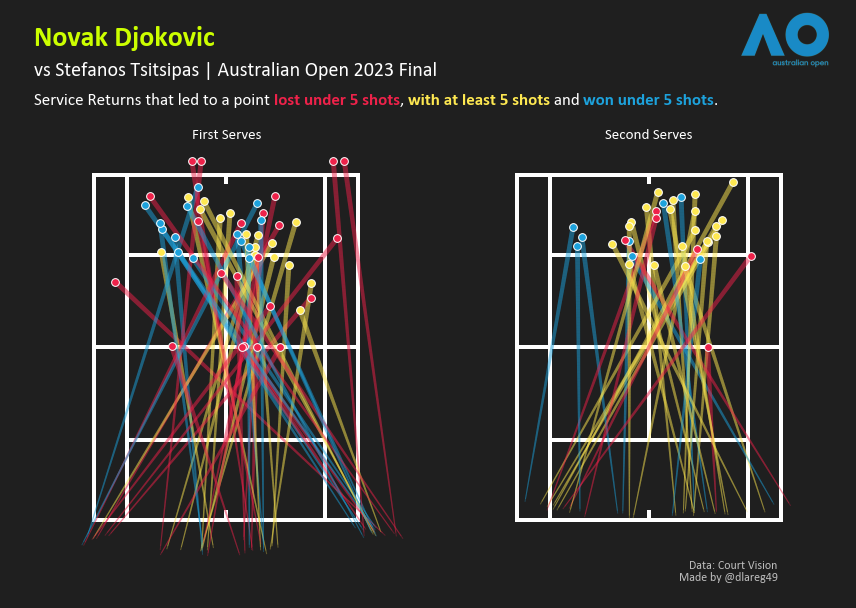

In [346]:
fig = plot_returns("ATPD643", "ATPTE51", "Novak Djokovic", 'Stefanos Tsitsipas', clr_split="Outcome")

In [347]:
fig.savefig("Djokovic_Returns_vs_Tsitsipas.png", bbox_inches='tight', dpi=300, facecolor=fig.get_facecolor())

31


C:\Users\lgjg1\AppData\Local\Temp\ipykernel_24608\2033216.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


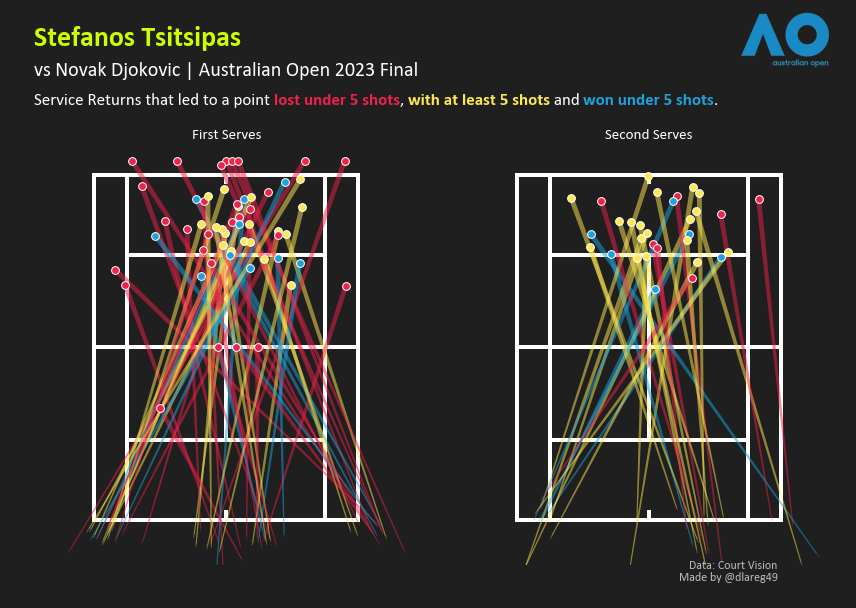

In [348]:
fig = plot_returns("ATPTE51", "ATPD643", 'Stefanos Tsitsipas', "Novak Djokovic", clr_split="Outcome")

In [349]:
fig.savefig("Tsitsipas_Returns_vs_Djokovic.png", bbox_inches='tight', dpi=300, facecolor=fig.get_facecolor())

In [38]:
from collections import namedtuple
from scipy.stats import binned_statistic_2d

def calc_binstat(x, y, bins, pitch_range):
    '''
    For Heatmap binning purposes
    '''

    _BinnedStatisticResult = namedtuple('BinnedStatisticResult',
                                        ('statistic', 'x_grid', 'y_grid', 'cx', 'cy'))

    x = np.ravel(x)
    y = np.ravel(y)

    values = np.ravel(x)

    #bins = (3,1)
    statistic = 'count'
    #pitch_range = [[-8.23/2, 0], [0,6.4]]
    statistic, x_edge, y_edge, _ = binned_statistic_2d(x, y, values, statistic=statistic,
                                                        bins=bins, range=pitch_range)

    statistic = statistic.T
    statistic = statistic / statistic.sum()

    x_grid, y_grid = np.meshgrid(x_edge, y_edge)

    cx, cy = np.meshgrid(x_edge[:-1] + 0.5 * np.diff(x_edge),
                            y_edge[:-1] + 0.5 * np.diff(y_edge))

    stats = _BinnedStatisticResult(statistic, x_grid, y_grid, cx, cy)._asdict()

    return stats

In [131]:
city_serves = df_points_sorted[(df_points_sorted.serverId=="ATPTE51") & ~df_points_sorted.pointEndType.isin(["Faulty Serve", "Ace", "DoubleFault"])]
city_serves_wrally = city_serves[city_serves.trajectoryData.apply(lambda x: len(x) >= 14)]

city_serves_wrally[city_serves_wrally.serve == 1].trajectoryData.iloc[0][5+3]

{'x': -7.782, 'y': 1.331, 'z': 0.032, 'position': 'bounce'}

In [152]:
def plot_retfaced(player, oppPlayer, df_points_sorted, playerName, oppName, round_n, clr_split="Side"):

    gs = gridspec.GridSpec(2,2, width_ratios=[1,1], height_ratios=[1,7])
    fig, axs = plt.subplots(figsize=(12, 6.5), facecolor="#1f1f1f", squeeze=False)

    ax = plt.subplot(gs[1,0])
    ax1 = plt.subplot(gs[1,1])
    ax_crts = [ax, ax1]

    city_serves = df_points_sorted[(df_points_sorted.serverId==player) & ~df_points_sorted.pointEndType.isin(["Faulty Serve", "Ace", "DoubleFault"])]
    city_serves_wrally = city_serves[city_serves.trajectoryData.apply(lambda x: len(x) >= 14)]

    data_1st_serv = city_serves_wrally[city_serves_wrally.serve == 1]
    data_2nd_serv = city_serves_wrally[city_serves_wrally.serve == 2]

    data_list = [data_1st_serv, data_2nd_serv]

    for j in range(2):

        ax_crts[j].set_facecolor("#1f1f1f")

        createTennisCourt(ax=ax_crts[j], lw=4, court_xlims=(-8,8), court_ylims=(-15,1))
        data_plot  = data_list[j]
    
        # Colour Split by Point Outcome
        if clr_split == "Outcome":
            y_list = []
            z_list = []
            x_retbouncelist = []
            y_retbouncelist = []
            for i in range(len(data_plot)):
                # Convert the point trajectory dict into a dataframe to extract the correct hit/bounce point information
                df_coords = pd.DataFrame(data_plot.trajectoryData.iloc[i])
                # Get indices of all the hit points
                i_hits = df_coords[df_coords.position == "hit"].index
                # Select relevant hit index (3rd shot is index 2)
                ind_ret = i_hits[1]
                ind = i_hits[2]
                # xy of the 3rd shot's hit and "bounce" point
                x = data_plot.trajectoryData.iloc[i][ind]['y']
                y = data_plot.trajectoryData.iloc[i][ind]['x']
                z = data_plot.trajectoryData.iloc[i][ind]['z']
                xend = data_plot.trajectoryData.iloc[i][ind+3]['y']
                yend = data_plot.trajectoryData.iloc[i][ind+3]['x']
                # bounce point of the opp's return
                x_retbounce = data_plot.trajectoryData.iloc[i][ind_ret+3]['y']
                y_retbounce = data_plot.trajectoryData.iloc[i][ind_ret+3]['x']
                bounce_TF = data_plot.trajectoryData.iloc[i][ind_ret+3]['position']
                if bounce_TF != "bounce":
                    print("not bounce")
                if y > 0:
                    x *= -1
                    y *= -1
                    xend *= -1
                    yend *= -1
                    x_retbounce *= -1
                    y_retbounce *= -1
                x *= -1
                xend *= -1
                x_retbounce *= -1
                # Append relevant coord values to lists
                y_list.append(y)
                x_retbouncelist.append(x_retbounce)
                y_retbouncelist.append(y_retbounce)
                z_list.append(z)

                ax_crts[j].scatter(x_retbounce, y_retbounce, zorder=10, \
                ec='w', s=60, c='w', alpha=0.3, lw=1)

                # # Plot Line Segments
                # _lines_no_cmap([x], [y], [xend], [yend], lw=np.linspace(1,5,100), \
                #             color=clr, ax=ax_crts[j], \
                #             n_segments=100, multi_segment=True, alpha=0.3)
                # ax_crts[j].scatter(xend, yend, zorder=10, \
                # ec='w', s=60, c=clr, alpha=1, lw=1)
                # ax_crts[j].scatter(x, y, zorder=10, \
                # ec='b', s=60, c='b', alpha=0.6, lw=1)
            print(np.mean(y_retbouncelist))
            print(np.mean(z_list))

            ##### +1 shot coords
            ax_crts[j].axhline(y=np.mean(y_list), c="#1DA2DC", ls="--")
            ax_crts[j].annotate( f"{np.round(np.mean(y_list),2)}m" , (6.75, np.mean(y_list)-1.75), c="#1DA2DC", va="top", ha="center", fontsize=14)
            ax_crts[j].annotate( "Avg. +1\ncontact" , (6.75, np.mean(y_list)-0.1), c="#1DA2DC", va="top", ha="center", fontsize=14)
            #ax_crts[j].axhline(y=np.median(y_list), c="lightblue", ls="--")
            ##### Return coords
            ax_crts[j].axhline(y=np.mean(y_retbouncelist), c="#FEE851", ls="--")
            ax_crts[j].annotate( "Avg. ret.\ndepth" , (6.75, np.mean(y_retbouncelist)+0.9), c="#FEE851", va="bottom", ha="center", fontsize=14)
            ax_crts[j].annotate( f"{np.round(np.mean(y_retbouncelist),2)}m" , (6.75, np.mean(y_retbouncelist)+0.1), c="#FEE851", va="bottom", ha="center", fontsize=14)
            #ax_crts[j].axhline(y=np.median(y_retbouncelist), c="lightgreen", ls="--")

        # Plot bounce heat map

        # Compute binned service hit points (split into third zones)
        stats = calc_binstat(x_retbouncelist, y_retbouncelist, (np.linspace(-8.23/2, 8.23/2, 5),[-11.89, -9.145 , -6.4, 0]), [[-8.23/2, 8.23/2], [-11.89,0]])

        ax_crts[j].pcolormesh(stats['x_grid'], stats['y_grid'], stats['statistic'], ec='w',alpha=0.8, vmin=0, vmax=0.29,linewidths=1, zorder=15)

        #ax[0][x].annotate(f"{starts[z]} Court", (stats['cx'][0][1], 8.5), c='white', ha='center', fontsize=18)

        for i in range(len(stats['statistic'])):
            for k, ratio in enumerate(stats['statistic'][i]):
                ratio = int(np.round(ratio*100))
                if ratio < 15:
                    fs = 14
                else:
                    fs = 16
                ax_crts[j].annotate(f"{ratio}%", (stats['cx'][i][k], stats['cy'][i][k]), c='white', va="center", ha='center', fontsize=fs, weight='bold', zorder=16)

    ax_crts[0].set_title('First Serves', fontsize=15, color='w')
    ax_crts[1].set_title('Second Serves', fontsize=15, color='w', y=1)

    # Figure Title
    ax2 = plt.subplot(gs[0,:])
    ax2.set_facecolor("#1f1f1f")

    if clr_split == 'Outcome':
        # You can use the wrapper around the class
        HighlightText(x=0, y=0,
                    s=f'Service <Returns Faced> and subsequent <+1 shot contact>.',
            highlight_textprops=[
                                {"color": '#FEE851', "weight": "bold",},
                                {"color": '#1DA2DC', "weight": "bold",}], fontsize=17, color='w',
            ax=ax2, va='center')

    
    # # Data source credit
    ax2.annotate(f'{playerName}', (0, 0.9), xycoords = 'axes fraction', fontsize=28, color=color_tit, ha='left', weight='bold')
    ax2.annotate(f'vs {oppName} | Australian Open 2023 {round_n}', (0, 0.4), xycoords = 'axes fraction', fontsize=20, color='w', ha='left')

    ax_crts[1].annotate('Data: Court Vision', (0.9, 0.065), xycoords = 'figure fraction', fontsize=12, color='w', alpha=0.7, ha='right')
    ax_crts[1].annotate('Made by @dlareg49', (0.9, 0.045), xycoords = 'figure fraction', fontsize=12, color='w', alpha=0.7, ha='right')

    #print(len(data_2nd_ret))

    a = Image.open("../../logos/AO.png")

    newax = fig.add_axes([0.85,0.895,0.125,0.125], anchor='C', zorder=15)
    newax.imshow(a, alpha=0.95)
    newax.axis('off')

    plt.subplots_adjust(hspace=0.15)
    plt.tight_layout()

    return fig, stats

not bounce
not bounce
-7.58675
0.875
-8.277344827586207
0.8671379310344828


C:\Users\lgjg1\AppData\Local\Temp\ipykernel_23796\838905481.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


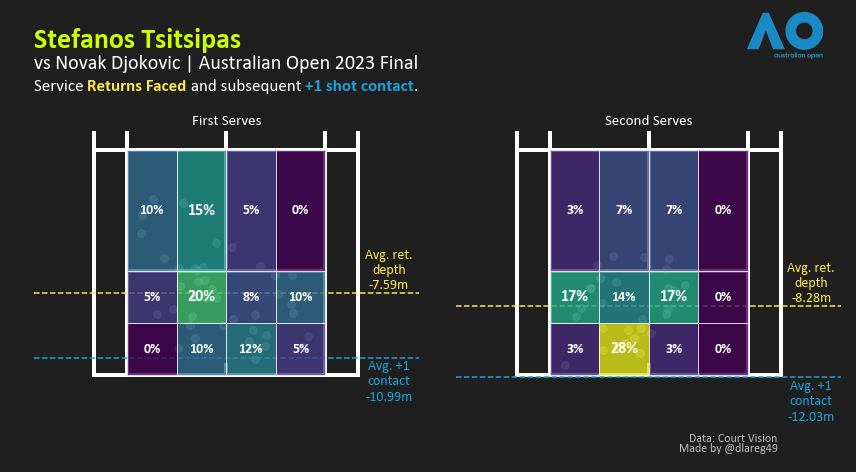

In [141]:
fig, stats = plot_retfaced("ATPTE51", "ATPD643",df_points_sorted, 'Stefanos Tsitsipas', "Novak Djokovic", "Final", clr_split="Outcome")

In [142]:
fig.savefig("Tsitsipas_Returnsfaced_vs_Djokovic.png", bbox_inches='tight', dpi=300, facecolor=fig.get_facecolor())

not bounce
-8.329690476190475
0.9988095238095237
-8.1479
1.235166666666667


C:\Users\lgjg1\AppData\Local\Temp\ipykernel_23796\838905481.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


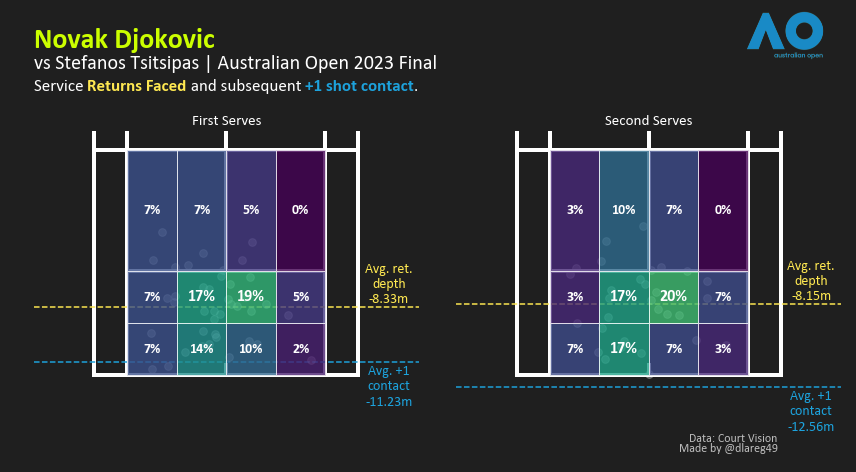

In [145]:
fig, stats = plot_retfaced("ATPD643", "ATPTE51", df_points_sorted, "Novak Djokovic", 'Stefanos Tsitsipas', "Final", clr_split="Outcome")

In [146]:
fig.savefig("Djokovic_Returnsfaced_vs_Tsitsipas.png", bbox_inches='tight', dpi=300, facecolor=fig.get_facecolor())

In [36]:
df_points_sorted_all = []
for file in glob.glob("../data/court-vision/raw/2023/580_*Stefanos-Tsitsipas*2023*.json")[1:]:
    # Read a sample data for processing example
    with open(file, 'r') as j:
        raw_data = json.loads(j.read())

    data_dict_1, df_points_sorted_1 = process_points_data(raw_data)

    df_points_sorted_all.append(df_points_sorted_1)

not bounce
not bounce
not bounce
not bounce
not bounce
not bounce
-7.533034934497816
1.046467248908297
not bounce
not bounce
not bounce
-8.026925925925926
0.9657925925925926


C:\Users\lgjg1\AppData\Local\Temp\ipykernel_23796\838905481.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


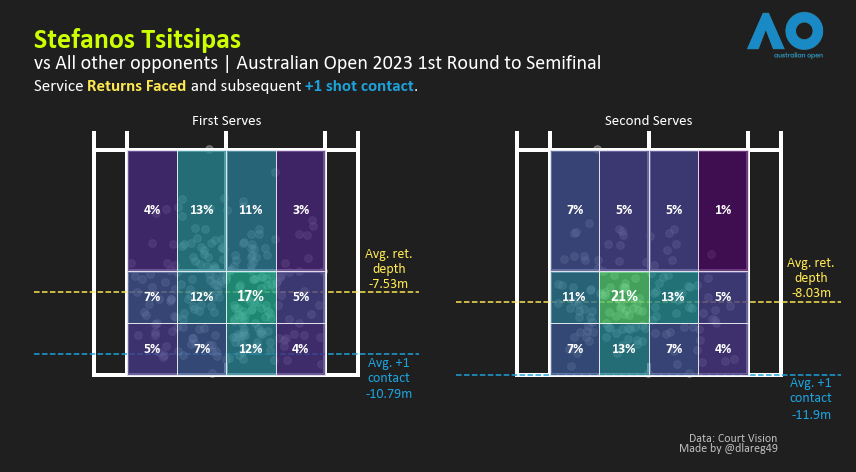

In [148]:
fig,stats = plot_retfaced("ATPTE51", "ATPD643", pd.concat(df_points_sorted_all), 'Stefanos Tsitsipas', "All other opponents", "1st Round to Semifinal", clr_split="Outcome")

In [149]:
fig.savefig("Tsitsipas_Returnsfaced_vs_Others.png", bbox_inches='tight', dpi=300, facecolor=fig.get_facecolor())

### Heatmap of all 3rd contact points

In [120]:
def plot_3rdshots_heat(player, oppPlayer, df_points_sorted, playerName, oppName, round_n, clr_split="Side"):
    gs = gridspec.GridSpec(2,2, width_ratios=[1,1], height_ratios=[1,7])
    fig, axs = plt.subplots(figsize=(12, 6.5), facecolor="#1f1f1f", squeeze=False)

    ax = plt.subplot(gs[1,0])
    ax1 = plt.subplot(gs[1,1])
    ax_crts = [ax, ax1]

    city_serves = df_points_sorted[(df_points_sorted.serverId==player) & ~df_points_sorted.pointEndType.isin(["Faulty Serve", "Ace", "DoubleFault"])]
    city_serves_wrally = city_serves[city_serves.trajectoryData.apply(lambda x: len(x) >= 14)]

    data_1st_serv = city_serves_wrally[city_serves_wrally.serve == 1]
    data_2nd_serv = city_serves_wrally[city_serves_wrally.serve == 2]

    data_list = [data_1st_serv, data_2nd_serv]

    for j in range(2):

        ax_crts[j].set_facecolor("#1f1f1f")

        createTennisCourt(ax=ax_crts[j], lw=4, court_xlims=(-8,8), court_ylims=(-15,1))
        data_plot  = data_list[j]
    
        # Colour Split by Point Outcome
        if clr_split == "Outcome":
            x_list = []
            y_list = []
            z_list = []
            x_retbouncelist = []
            y_retbouncelist = []
            for i in range(len(data_plot)):
                # Convert the point trajectory dict into a dataframe to extract the correct hit/bounce point information
                df_coords = pd.DataFrame(data_plot.trajectoryData.iloc[i])
                # Get indices of all the hit points
                i_hits = df_coords[df_coords.position == "hit"].index
                # Select relevant hit index (3rd shot is index 2)
                ind_ret = i_hits[1]
                ind = i_hits[2]
                # xy of the 3rd shot's hit and "bounce" point
                x = data_plot.trajectoryData.iloc[i][ind]['y']
                y = data_plot.trajectoryData.iloc[i][ind]['x']
                z = data_plot.trajectoryData.iloc[i][ind]['z']
                xend = data_plot.trajectoryData.iloc[i][ind+3]['y']
                yend = data_plot.trajectoryData.iloc[i][ind+3]['x']
                # bounce point of the opp's return
                x_retbounce = data_plot.trajectoryData.iloc[i][ind_ret+3]['y']
                y_retbounce = data_plot.trajectoryData.iloc[i][ind_ret+3]['x']
                if y > 0:
                    x *= -1
                    y *= -1
                    xend *= -1
                    yend *= -1
                    x_retbounce *= -1
                    y_retbounce *= -1
                x *= -1
                xend *= -1
                x_retbounce *= -1
                # Append relevant coord values to lists
                x_list.append(x)
                y_list.append(y)
                x_retbouncelist.append(x_retbounce)
                y_retbouncelist.append(y_retbounce)
                z_list.append(z)

                ax_crts[j].scatter(x_list, y_list, zorder=10, \
                ec='w', s=60, c='w', alpha=0.3, lw=1)

                
            print(np.mean(y_retbouncelist))
            print(np.mean(z_list))

            ##### +1 shot coords
            ax_crts[j].axhline(y=np.mean(y_list), c="#1DA2DC", ls="--")
            ax_crts[j].annotate( f"{np.round(np.mean(y_list),2)}m" , (6.75, np.mean(y_list)-1.75), c="#1DA2DC", va="top", ha="center", fontsize=14)
            ax_crts[j].annotate( "Avg. +1\ncontact" , (6.75, np.mean(y_list)-0.1), c="#1DA2DC", va="top", ha="center", fontsize=14)
            #ax_crts[j].axhline(y=np.median(y_list), c="lightblue", ls="--")
            ##### Return coords
            ax_crts[j].axhline(y=np.mean(y_retbouncelist), c="#FEE851", ls="--")
            ax_crts[j].annotate( "Avg. ret.\ndepth" , (6.75, np.mean(y_retbouncelist)+0.9), c="#FEE851", va="bottom", ha="center", fontsize=14)
            ax_crts[j].annotate( f"{np.round(np.mean(y_retbouncelist),2)}m" , (6.75, np.mean(y_retbouncelist)+0.1), c="#FEE851", va="bottom", ha="center", fontsize=14)
            #ax_crts[j].axhline(y=np.median(y_retbouncelist), c="lightgreen", ls="--")

        # Plot bounce heat map

        # Compute binned service hit points (split into third zones)
        xbins = [-6,  -8.23/2, -8.23/4, 0, 8.23/4, 8.23/2, 6]
        ybins = [-14, -11.89, -9.145 , -6.4, 0]
        stats = calc_binstat(x_list, y_list, (xbins, ybins), [[-6, 6], [-14,0]])

        ax_crts[j].pcolormesh(stats['x_grid'], stats['y_grid'], stats['statistic'], ec='w',alpha=0.8, vmin=0, vmax=0.29,linewidths=1, zorder=15)

        #ax[0][x].annotate(f"{starts[z]} Court", (stats['cx'][0][1], 8.5), c='white', ha='center', fontsize=18)

        for i in range(len(stats['statistic'])):
            for k, ratio in enumerate(stats['statistic'][i]):
                ratio = int(np.round(ratio*100))
                if ratio < 15:
                    fs = 14
                else:
                    fs = 16
                ax_crts[j].annotate(f"{ratio}%", (stats['cx'][i][k], stats['cy'][i][k]), c='white', va="center", ha='center', fontsize=fs, weight='bold', zorder=16)

    ax_crts[0].set_title('First Serves', fontsize=15, color='w')
    ax_crts[1].set_title('Second Serves', fontsize=15, color='w', y=1)

    # Figure Title
    ax2 = plt.subplot(gs[0,:])
    ax2.set_facecolor("#1f1f1f")

    if clr_split == 'Outcome':
        # You can use the wrapper around the class
        HighlightText(x=0, y=0,
                    s=f'Service Returns faced and subsequent +1 shot contact points.',
            highlight_textprops=[], fontsize=17, color='w',
            ax=ax2, va='center')

    
    # # Data source credit
    ax2.annotate(f'{playerName}', (0, 0.9), xycoords = 'axes fraction', fontsize=28, color=color_tit, ha='left', weight='bold')
    ax2.annotate(f'vs {oppName} | Australian Open 2023 {round_n}', (0, 0.4), xycoords = 'axes fraction', fontsize=20, color='w', ha='left')

    ax_crts[1].annotate('Data: Court Vision', (0.9, 0.065), xycoords = 'figure fraction', fontsize=12, color='w', alpha=0.7, ha='right')
    ax_crts[1].annotate('Made by @dlareg49', (0.9, 0.045), xycoords = 'figure fraction', fontsize=12, color='w', alpha=0.7, ha='right')

    #print(len(data_2nd_ret))

    a = Image.open("../../logos/AO.png")

    newax = fig.add_axes([0.85,0.895,0.125,0.125], anchor='C', zorder=15)
    newax.imshow(a, alpha=0.95)
    newax.axis('off')

    plt.subplots_adjust(hspace=0.15)
    plt.tight_layout()

    return fig, stats

-7.533034934497816
1.046467248908297
-8.026925925925926
0.9657925925925926


C:\Users\lgjg1\AppData\Local\Temp\ipykernel_23796\943289069.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


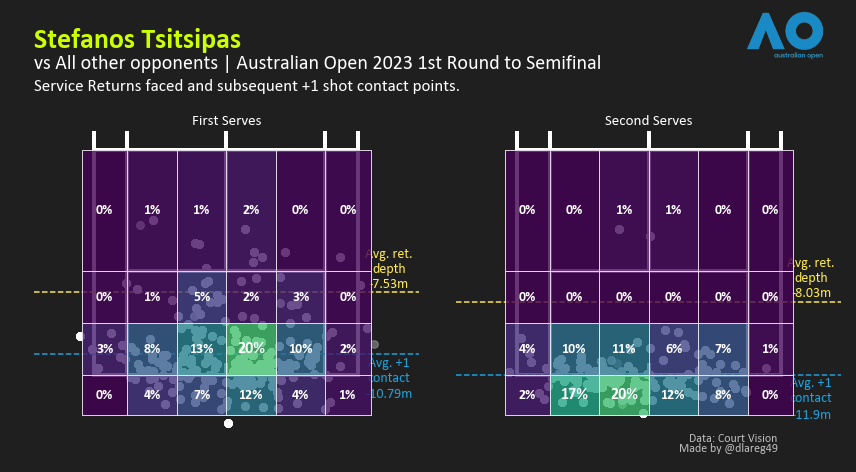

In [125]:
fig, stats = plot_3rdshots_heat("ATPTE51", "ATPD643",pd.concat(df_points_sorted_all), 'Stefanos Tsitsipas', "All other opponents", "1st Round to Semifinal", clr_split="Outcome")

-7.58675
0.875
-8.277344827586207
0.8671379310344828


C:\Users\lgjg1\AppData\Local\Temp\ipykernel_23796\943289069.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


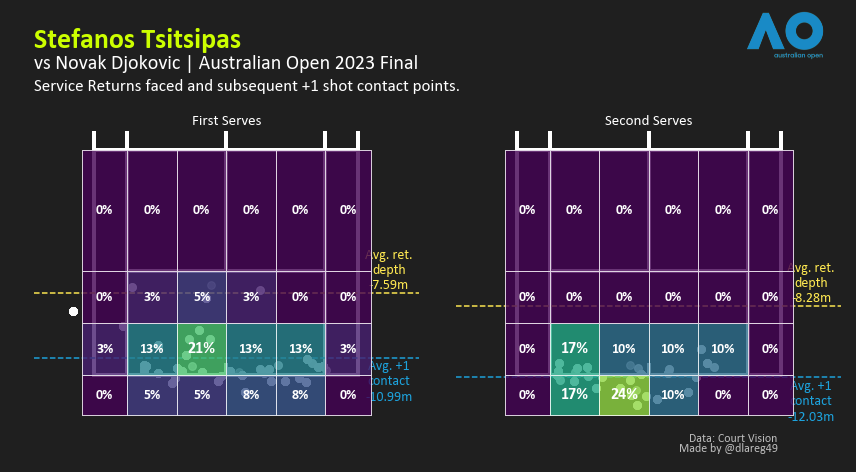

In [122]:
fig, stats = plot_3rdshots_heat("ATPTE51", "ATPD643",df_points_sorted, 'Stefanos Tsitsipas', "Novak Djokovic", "Final", clr_split="Outcome")